Experiment with implementing a random zoom augmentation

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

In [4]:
# Preprocessing function
stddev = 0.017359
def preprocess(data):
  image = data['image']
  image = tf.clip_by_value(image, 0.0, 10.0)
  image = tf.math.asinh(image/stddev)
  return image

In [5]:
initial_dataset = (tfds.load('hsc_icl', split='train'))
dataset = initial_dataset.map(preprocess)

2023-06-13 13:42:10.513863: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[21. 17. 24. 32.]


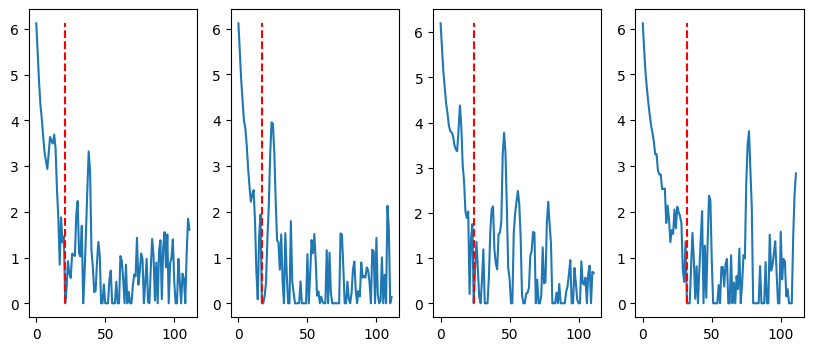

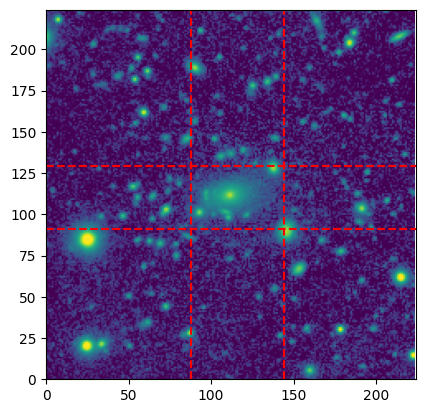

In [30]:
plt.figure(figsize=(10,4))
# Skip a random number of elements
to_skip = np.random.randint(2376)
curr = 0

for d in dataset:
    if curr < to_skip:
        curr += 1
        continue

    # Measure image profile from centre along the four cardinal directions
    img = d.numpy().squeeze()
    mid = (img.shape[0] // 2, img.shape[1] // 2)

    north = img[0:mid[0], mid[1]][::-1] # Reverse north and west so peak starts from 0
    south = img[mid[0]:, mid[1]]
    west = img[mid[0], 0:mid[1]][::-1]
    east = img[mid[0], mid[1]:]

    # Which direction has the widest peak 
    peak_widths = np.zeros((4))

    # Plot profiles
    for i,line in enumerate([north, south, west, east]):
        width = np.where(line < 0.006)[0]
        if len(width) == 0:
            width = img.shape[0]
        else:
            width = width[0]
        peak_widths[i] = width

        plt.subplot(1, 4, i+1)
        plt.plot(line)
        plt.plot([width, width], [0, max(line)], c='red', linestyle='--')
    
    print(peak_widths)

    break

plt.show()

# Show the original image with a box superimposed
plt.imshow(img)
plt.plot([0, img.shape[1]], [mid[1] - peak_widths[0], mid[1] - peak_widths[0]], c='red', linestyle='--')
plt.plot([0, img.shape[1]], [mid[1] + peak_widths[1], mid[1] + peak_widths[1]], c='red', linestyle='--')
plt.plot([mid[0] - peak_widths[2], mid[0] - peak_widths[2]], [0, img.shape[0]], c='red', linestyle='--')
plt.plot([mid[0] + peak_widths[3], mid[0] + peak_widths[3]], [0, img.shape[0]], c='red', linestyle='--')
plt.xlim(0, img.shape[1])
plt.ylim(0, img.shape[0])
plt.show()

tf.Tensor(
[0.4375     0.50892857 0.78571429 0.57142857 0.3125     0.24107143
 0.82142857 0.41071429 0.30357143 0.24107143 0.35714286 0.4375
 1.         0.17857143 1.         0.45535714], shape=(16,), dtype=float64)


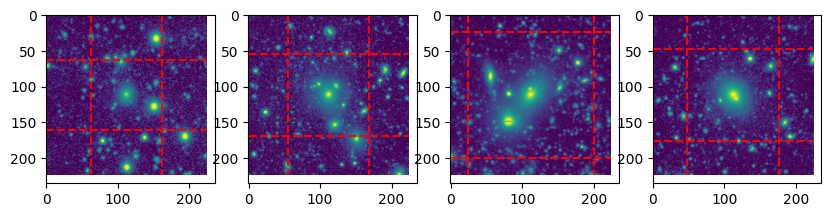

In [62]:
# Perform the calculation on the entire batch at once
batch_size = 16
initial_dataset = (tfds.load('hsc_icl', split='train')
                   .shuffle(buffer_size=1000)
                   .batch(batch_size, drop_remainder=True))

dataset = initial_dataset.map(preprocess)

for batch in dataset:
    _, height, width, _ = batch.shape

    mid = [height // 2, width // 2]

    norths = tf.reverse(batch[:, 0:mid[0], mid[1], :], axis=[1])
    souths = batch[:, mid[0]:, mid[1], :]
    wests = tf.reverse(batch[:, mid[0], 0:mid[1], :], axis=[1])
    easts = batch[:, mid[0], mid[1]:]

    max_widths = tf.ones(batch_size, dtype=tf.dtypes.int64) * 20 # Import minimum width of 40x40 box

    for lines in [norths, souths, wests, easts]:
        widths = tf.squeeze(tf.math.argmax(lines < 0.006, axis=1)) # Find half widths of peaks
        widths_fixed = tf.where(widths == 0, height // 2, widths) # If not found, default to normal size of image
        max_widths = tf.math.maximum(max_widths, widths_fixed) # Find the new maximum widths

    max_zoom = max_widths * 2 / height
    print(max_zoom)

    plt.figure(figsize=(10,4))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        img = batch[i].numpy().squeeze()
        plt.imshow(img)
        plt.plot([0, img.shape[1]], [mid[1] - max_widths[i], mid[1] - max_widths[i]], c='red', linestyle='--')
        plt.plot([0, img.shape[1]], [mid[1] + max_widths[i], mid[1] + max_widths[i]], c='red', linestyle='--')
        plt.plot([mid[0] - max_widths[i], mid[0] - max_widths[i]], [0, img.shape[0]], c='red', linestyle='--')
        plt.plot([mid[0] + max_widths[i], mid[0] + max_widths[i]], [0, img.shape[0]], c='red', linestyle='--')

    plt.show()
    break
